### Predicting London Electricity Consumption Using Time Series Models

In this notebook we will look at predicting electricity consumption in London using Time Series models. The dataset is a time series from smart-meters in London from the end of 2011 to the start 2014. It contains the daily consumption (kWh) averaged over several households in London.

We will try to find a model to forecast the consumption in the final month of the dataset (January 2014). We will comapare results from an ARIMA model with those from Facebook's Prophet forecasting tool.

In [1]:
# First let's import the required libraries

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
%matplotlib inline

from statsmodels.api import tsa
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_absolute_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Next we can import the data, we parse the day column into datetime format and set it as the index
df = pd.read_csv("data/data.zip", parse_dates=["day"] ,index_col="day")
df.head()

,consumption
day,
2011-11-24,7.7580
2011-11-25,8.7385
2011-11-26,9.4770
2011-11-27,9.8030
2011-11-28,7.0690


In [3]:
# Let's look at the shape and dataframe info
print(df.shape)
df.info()

(800, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 2011-11-24 to 2014-01-31
Data columns (total 1 columns):
consumption    800 non-null float64
dtypes: float64(1)
memory usage: 12.5 KB


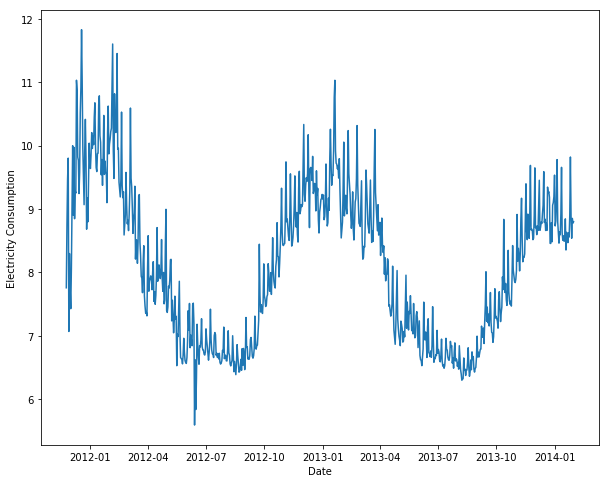

In [4]:
# Let's plot the data

plt.figure(figsize=(10,8))
plt.plot( df.index, df['consumption'])
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.show()

We can see that in general there is a slight reduction in electricity consumption over the period of the dataset. At the same time there is clear seasonality, there seems to be two levels one weekly (with peak usage on Sundays) and a more obvious half-yearly seasonality (winter-summer-winter). This fits well with what we would expect for electricity consumption data.

In [5]:
# Split the dataset into train and test set for predicting the last 31 days (January 2014)
df_train = df[:-31]
df_test = df[-31:]
y_test = df_test[["consumption"]]
df_test.drop(columns=["consumption"], axis=1, inplace=True)

### ARIMA

The ARIMA model is a popular and widley used statistical method for Time Series Forcasting. It stands for Auto-Regression Integrated Moving Average. It is a generalisation of the simpler ARMA model to which it adds an integration element. The ARMA model can written as follows, with a Auto-Regression part and a Moving Average part:

$$
y_{t} = c + \underbrace{ \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} }_{AR(p)} + \underbrace{ \theta_{1}e_{t-1} + \theta_{2}e_{t-2} + \dots + \theta_{q}e_{t-q} }_{MA(q)} +e_{t},
$$

Let's breakdown the different components of the model to understand it a little better:
* Autoregression => models the relationship between an observation and some defined number of lagged observations (for example we might try to predict the next days electricity consumption using data from the last 7 days, here the lag will be 7)
* Integration => is incorporated to ensure a stationary time series for modelling. Essentially a technique called differencing is used (subtracting an observation from an observation at the previous timestep, for example) to generate a stationary time series. The stationary time series should have constant mean and standard deviation across the series.
* Moving Average => this component is used to fit trends in the noise which can't be modelled by the AR component alone. Essentially we are using the error at t-1 as a useful predictor for time t.

The order parameters of the ARIMA model are (p, d, q) and are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window.

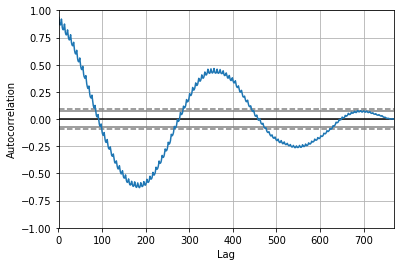

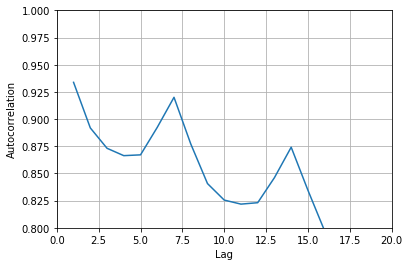

In [6]:
# It is often insightful to look at the auto-correlation plot of a time series
# It shows the correlation between observations at different lags

autocorrelation_plot(df_train)
plt.show()
autocorrelation_plot(df_train)
plt.xlim((0, 20))
plt.ylim((0.8, 1.0))
plt.show()

We can see there is strong positive correlation between observation over lag values of 0 - 10. It is probably worth looking in this range for the optimum lag order. We will try to optimise the order parameter later.

                             ARIMA Model Results                              
Dep. Variable:          D.consumption   No. Observations:                  768
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -258.777
Method:                       css-mle   S.D. of innovations              0.338
Date:                Mon, 10 Jun 2019   AIC                            535.554
Time:                        15:49:51   BIC                            577.348
Sample:                    11-25-2011   HQIC                           551.640
                         - 12-31-2013                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0005      0.005      0.098      0.922      -0.010       0.011
ar.L1.D.consumption     0.6516      0.039     16.508      0.000       0.574       0.729
ar.L2.D.consumpt

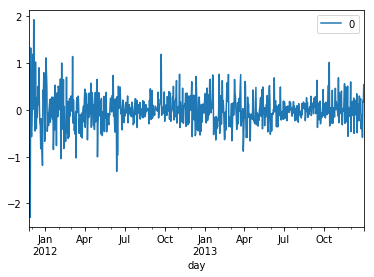

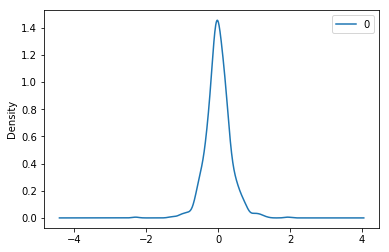

                0
count  768.000000
mean     0.002071
std      0.347246
min     -2.300713
25%     -0.178004
50%     -0.007703
75%      0.179758
max      1.932009


In [49]:
# Let's start by looking at a model with lag=7 and differencing of 1.

model = ARIMA(df_train, order=(7,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde', label="residuals")
plt.ylabel("Residuals")
plt.legend()
plt.show()
print(residuals.describe())

The summary details information about the model including the coefficient and the errors associated with the different lags. We also plot the residuals, which look stationary, with a mean of 0 and a fairly constant variance. This is important.

Let's fit this initial model to the training data and try to make 31 days of predictions for January 2014. Here we use the training data up to 31st December 2013 to make the first prediction for 1st Jan 2014. We then append this prediction to the model input to make the next prediction and so on.

predicted=8.684470, expected=9.535000
predicted=8.711546, expected=8.734000
predicted=8.821780, expected=8.812000
predicted=8.676542, expected=9.144000
predicted=9.001477, expected=9.780000
predicted=9.046280, expected=8.794000
predicted=9.061461, expected=8.628000
predicted=8.753592, expected=8.462500
predicted=8.798544, expected=8.642500
predicted=8.830823, expected=8.595000
predicted=8.769279, expected=8.927500
predicted=8.959105, expected=9.658000
predicted=8.998215, expected=8.625000
predicted=8.981909, expected=8.508000
predicted=8.802911, expected=8.577000
predicted=8.842832, expected=8.492000
predicted=8.845041, expected=8.499000
predicted=8.822472, expected=8.845000
predicted=8.935433, expected=8.354000
predicted=8.964315, expected=8.633000
predicted=8.939071, expected=8.611000
predicted=8.837752, expected=8.470000
predicted=8.866958, expected=8.621000
predicted=8.859547, expected=8.558000
predicted=8.854154, expected=8.901500
predicted=8.922530, expected=9.821000
predicted=8.

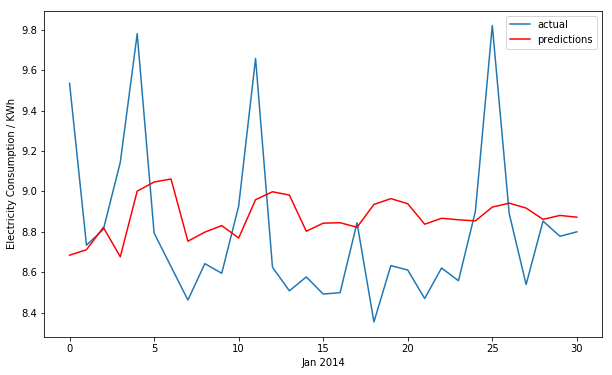

In [7]:
test = y_test.values
train = df_train.values
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)
# plot
plt.figure(figsize=(10, 6))
plt.plot(test, label="actual")
plt.plot(predictions, color='red', label="predictions")
plt.xlabel("Jan 2014")
plt.ylabel("Electricity Consumption / KWh")
plt.legend()
plt.show()

We can see that the predictions try to model the weekly seasonality but the peaks are not well fit and this seems to get worse as the prediction goes on. We can try to tune the order parameters (p, d, q) using the following two functions:

In [8]:
def arima_eval(time_series, order):
    """Splits the time_series data into training and test
    sets. It fits an ARIMA model to the training data and
    predicts over the test data period appending the previous prediction
    to history to make the next prediction"""
    train, test = time_series[:-31], time_series[-31:]
    history = [x for x in train]
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(yhat)

    error = mean_absolute_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    """Takes lists of p, d and q values for the ARIMA order
    parameter. Fits an ARIMA model and predicts using the arima_eval
    function for all possible combination of p, d and q. Returns the best 
    combination."""
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    order_combs = [p_values, d_values, q_values]
    orders = list(itertools.product(*order_combs))
    for order in orders:
        try:
            mae = arima_eval(dataset, order)
            if mae < best_score:
                best_score, best_cfg = mae, order
                print('ARIMA%s MAE=%.3f' % (order, mae))
        except:
            continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
 

# evaluate parameters
p_values = [1, 3, 5, 7]
d_values = [1, 2]
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(1, 1, 0) MAE=0.528
ARIMA(1, 1, 1) MAE=0.370
ARIMA(1, 1, 2) MAE=0.367
ARIMA(1, 1, 3) MAE=0.361
ARIMA(3, 1, 1) MAE=0.351
ARIMA(5, 1, 0) MAE=0.347
ARIMA(5, 1, 1) MAE=0.335
ARIMA(5, 1, 2) MAE=0.315
ARIMA(7, 1, 3) MAE=0.313
Best ARIMA(7, 1, 3) MAE=0.313


predicted=8.656183, expected=9.535000
predicted=8.653201, expected=8.734000
predicted=8.807029, expected=8.812000
predicted=8.729619, expected=9.144000
predicted=9.025159, expected=9.780000
predicted=9.098023, expected=8.794000
predicted=9.098578, expected=8.628000
predicted=8.745545, expected=8.462500
predicted=8.723105, expected=8.642500
predicted=8.798855, expected=8.595000
predicted=8.816880, expected=8.927500
predicted=8.989353, expected=9.658000
predicted=9.060362, expected=8.625000
predicted=9.027132, expected=8.508000
predicted=8.796616, expected=8.577000
predicted=8.764656, expected=8.492000
predicted=8.810335, expected=8.499000
predicted=8.858901, expected=8.845000
predicted=8.969713, expected=8.354000
predicted=9.025110, expected=8.633000
predicted=8.983037, expected=8.611000
predicted=8.829495, expected=8.470000
predicted=8.796089, expected=8.621000
predicted=8.828287, expected=8.558000
predicted=8.881326, expected=8.901500
predicted=8.957820, expected=9.821000
predicted=8.

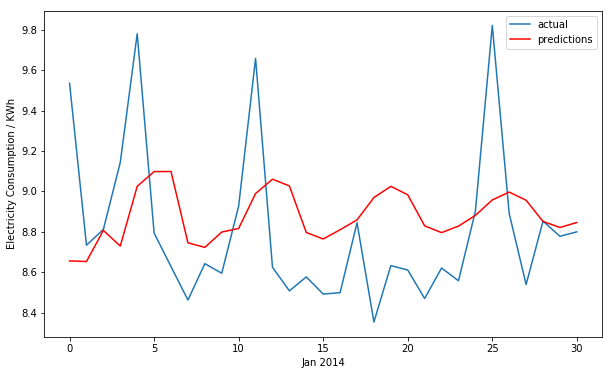

In [9]:
# Let's input the best order values and see if we see any improvement

history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(7,1,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)
# plot
plt.figure(figsize=(10, 6))
plt.plot(test, label="actual")
plt.plot(predictions, color='red', label="predictions")
plt.xlabel("Jan 2014")
plt.ylabel("Electricity Consumption / KWh")
plt.legend()
plt.show()

This looks slightly better but it is still a long way off modelling the peaks.

In [10]:
# Another useful forecasting metric in the Mean Absolute Percentage Error (MAPE)
# Let's check that as well

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true))

In [11]:
mape(test, predictions)

0.03506612560843498

Let's now try to fit a model using Facebook's Prophet forecasting tool

## The Prophet model

The idea behind the prophet package is to decompose time series data into the following three components:

- trends: these are non-periodic and systematic trends in the data,
- seasonal effects: these are modelled as daily or yearly periodicities in the data (optionally also hourly)
- holiday/one-off effects: these are effectively outliers.
 
Each of these components contribute *additively* to the observed time series. In other words, the electricity consumption on any give day is *the sum* of the trend component, the seasonal component and the one-off effects. As a result, the model can be mathematically written as follows:

$$ y(t) = g(t) + s(t) + h(t) + \epsilon_t $$

where $y(t)$ is the electricity consumption on day $t$ and $g(t), s(t)$ and $h(t)$ correspond to the growth trend, seasonal effects and holiday effects respectively. Finally, $\epsilon_t$ accounts for noise. 

The approach taken in the Prophet packge is different from traditional forecasting models such as [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) models. For example, note that $y(t)$ is not a function of $y(t-1)$ but instead a function of the growth, season and holiday effects. The main advantages of taking an additive approach are as follows.

- It provides us with more flexibility. For example, we can easily accomodate irregular measurements.
- We can directly interpret each of the additive components and thus untangle the contributions of each aspect to the forecasts. This is important when we look to understand how the data was generated.
 
Let's look at each component of the model in a bit more detail:

### Trend component

The default trend component in the Prophet package is a linear growth trend with some changepoints. If there are no changepoints, this means that the growth with continue to grow at some linear rate such that:

$$ g(t) = \alpha t$$

Changepoints are introduced so that the linear rate of growth can vary. For example, it may be the case that there was 2% daily growth (corresponding to $g(t) = 1.02 \times t$) for the first year and 1% daily growth (so that $g(t) = 1.01 \times t$) afterwards.

### Seasonal components

Seasonality is a crucial component of many time-series and is clearly present in the Electricity consumption data we study here. The approach taken in the Prophet package is to consider various seasonal components with varying periodicities. For example, we may have one component with a periodicity of 7 days to capture weekly effects, and another with a periodicity of 365 days to capture yearly effects. By default, the Prophet package includes weekly and yearly seasonalities. This is what makes the most sense in this example, but it is also possible to include other seasonalities.

### Holidays/outliers 

Finally, a well-document difficulty with time-series and forecasting data is the presence of outliers. These are data points which deviate significantly from the distribution of the remainder of the data. If these points are ignored they may possibly lead to poor forecasts and so it is important to consider these points carefully. For example a power-cut in the Electricity data would correspond to a holiday/outlier as may extremely hot or cold days.

The Prophet package directly allows for such events by allowing the user to input a list of days which were holidays or potential outliers. The holiday component to the model is then:

$$
h(t) =
\begin{cases}
\kappa & \mbox{if $t$ is a holiday/outlier}\\
0 & \mbox{otherwise}
\end{cases}
$$

In this way the scalar $\kappa$ accounts for large positive/negative values of holidays or potential outliers.

In [12]:
# Let's reload the data as Prophet requires the data to be inputted in a slightly different format

df = pd.read_csv("data/data.zip", parse_dates=["day"])
df.head()

,day,consumption
0,2011-11-24,7.7580
1,2011-11-25,8.7385
2,2011-11-26,9.4770
3,2011-11-27,9.8030
4,2011-11-28,7.0690


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
day            800 non-null datetime64[ns]
consumption    800 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.6 KB


In [14]:
# The prophet package expects input as a dataframe with the first column indicating time and 
# the second indicating the time series we wish to forecast

df['day'] = pd.DatetimeIndex(df['day'])
df_prepared = df.rename(columns={'day': 'ds', 'consumption': 'y'})

In [15]:
# Let's split the data into train and test sets

df_train = df_prepared[:-31]
df_test = df_prepared[-31:]
y_test = df_test["ds"]
df_test.drop(columns="ds", axis=1, inplace=True)

Prophet is very easy to implement. It tends to perform very well straight out of the box. Further optimisation can be carried out by tuning various hyperparameters which will be discussed later. It also has an inbuilt CV function for validation:

In [16]:
# Let's fit the model to the training data

forecast_model = Prophet(growth='linear')
forecast_model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We can then use the in-built CV functionality to fit on a certain slice of the training data and predict on a certain period. The 'initial' parameter determines what proportion of the data to train on initially, the 'horizon' is the number of days we predict. This process is then repeated by adding the 'period' to the initial input.

In [17]:
df_cv = cross_validation(forecast_model, initial= '550 days', period= '31 days', horizon = '31 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2013-05-28 00:00:00 and 2013-11-30 00:00:00


In [18]:
# df_cv is a dataframe with the 31 predictions for each of the 7 cut-offs. Here we look at the first prediction for each horizon.
print(df_cv.shape)
df_cv.iloc[::31]

(217, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-05-29,6.774072,6.228709,7.283927,7.3820,2013-05-28
31,2013-06-29,7.044165,6.554854,7.535013,6.6900,2013-06-28
62,2013-07-30,6.543890,6.038879,7.035967,6.6380,2013-07-29
93,2013-08-30,6.421093,5.935213,6.935182,6.5015,2013-08-29
124,2013-09-30,7.529406,7.038466,7.991648,7.2815,2013-09-29
155,2013-10-31,8.214739,7.811130,8.708209,7.8400,2013-10-30
186,2013-12-01,9.459321,9.003732,9.923300,9.6495,2013-11-30


In [19]:
# We can also look at the fit quality across different horizons. Here we just show the metrics for the 31 day horizons
df_p = performance_metrics(df_cv)
df_p[df_p["horizon"] == "31 days"]

,horizon,mse,rmse,mae,mape,coverage
30,31 days,0.179373,0.423524,0.321480,0.041640,0.714286
92,31 days,0.176990,0.420701,0.311495,0.040102,0.714286
154,31 days,0.202207,0.449674,0.338638,0.043343,0.666667
123,31 days,0.201911,0.449345,0.338253,0.043000,0.666667
185,31 days,0.166781,0.408389,0.298900,0.038352,0.714286
61,31 days,0.166415,0.407940,0.298109,0.038643,0.714286
216,31 days,0.137356,0.370616,0.266916,0.034874,0.761905


In [20]:
# We can also choose a different horizon, say 10 days
df_p[df_p["horizon"] == "10 days"]

,horizon,mse,rmse,mae,mape,coverage
164,10 days,0.092209,0.303659,0.251129,0.034154,0.857143
102,10 days,0.092530,0.304187,0.252874,0.034464,0.857143
9,10 days,0.089320,0.298865,0.245052,0.033310,0.857143
195,10 days,0.096575,0.310765,0.256072,0.034207,0.857143
40,10 days,0.091218,0.302023,0.250042,0.033813,0.904762
71,10 days,0.090657,0.301092,0.248606,0.033655,0.904762
133,10 days,0.092477,0.304100,0.257753,0.034894,0.904762


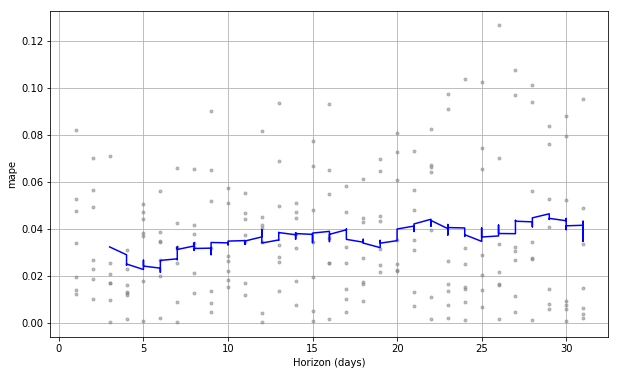

In [21]:
# Here we plot how the MAPE changes with increasing the horizon.
# As one would expect we see an slight increase in error as the prediction horizon is extended
# This is a useful metric when determining how far ahead to make predictions depending on acceptable prediction error.

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

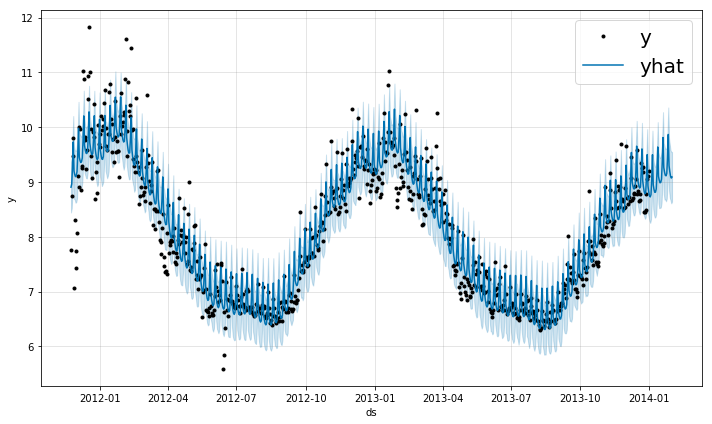

In [22]:
# For evaluation we need to pass the model the prediction dates. 
# Prophet can generate these if you tell it how many periods (in this case days) to add onto the training data.
# You can choose to include the training data or not, with "include_history"
# It also has a plot function for plotting the predictions

df_dates = forecast_model.make_future_dataframe(periods=31, 
                                                include_history=True)
model_predictions = forecast_model.predict(df_dates)
plot_pred = forecast_model.plot(model_predictions)
plt.legend(loc='best', fontsize=20)
plot_pred
plt.show()

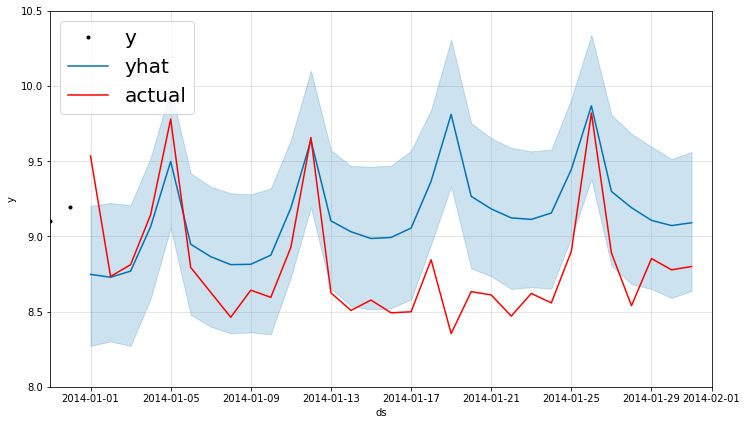

In [23]:
# Here we remove the history and include the actual data and focus the graph just on the predictions.

df_dates = forecast_model.make_future_dataframe(periods=31, 
                                                include_history=False)
model_predictions = forecast_model.predict( df_dates )
plot_pred = forecast_model.plot( model_predictions )
plt.plot(df_dates, df_test, label="actual", color="r")
plt.legend(loc='best', fontsize=20)
plt.xlim('2013-12-30', '2014-02-01')
plt.ylim(8.0, 10.5)
plot_pred
plt.show()

With Prophet we seem to be able to model the weekly seasoanlity much better than with the ARIMA model

In [25]:
# Let's have a look at the MAPE

mape(df_test, model_predictions["yhat"])

0.05575155652250795

That's interesting. It's a bit higher than the ARIMA model. This may be due to the 3rd week of January, where the weekly seasonality of having peak consumption on the Sunday is not followed.

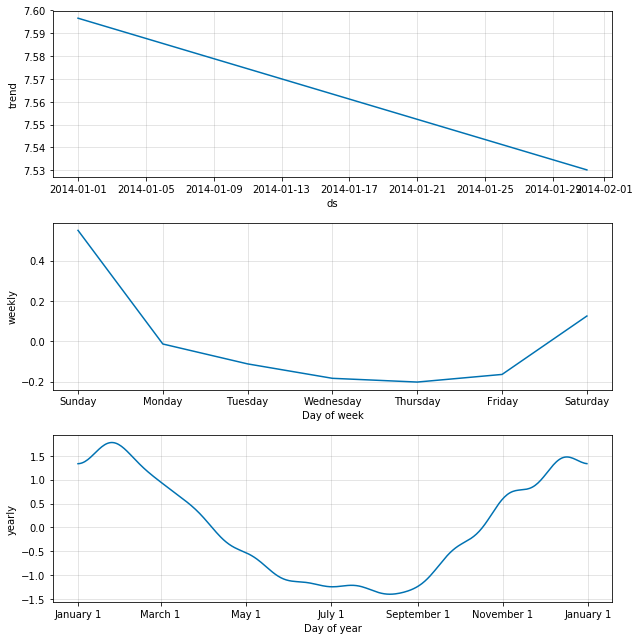

In [26]:
# Prophet also allows us to access the model components, namely the general trend and the weekly and yearly seasonality.

forecast_model.plot_components( forecast_model.predict(df_dates), 
                               uncertainty=False )
plt.show()

Prophet also has a number of parameters and hyperparamters for tuning:

### Holidays
We mentioned this earlier. It is basically an user input to take care of outliers. The user inputs a dataframe of "holidays" to the model. For example if we knew that certain days there was a power outage in London, we could input these dates. It might also be interesting to include UK bank holidays.

### Changepoints
These are points in your data where there is a sudden change in the general trend. Prophet automatically models these changepoints but you can specify/tune them using the hyperparameters. There are 3 main hyperparameters for changepoints:
* changepoints - here you input the dates of the changepoints
* n_changepoints - you tell prophet how many changepoints there are and it models them
* changepoint_prior_scale - this determines how flexible the changepoints are (higher means more flexible)

### Seasonality
There is also a lot of flexibility to tune the seasonality of your model. First there is "seasonality_mode" which can either be additive or multplicative. As default Prophet uses additive seasonality, meaning the effect of seasonality is added to the trend to get the forecast as we detailed above. However, there are cases where the seasonality is not a constant additive factor as assumed by Prophet, rather it grows with the trend. This is multiplicative seasonality and can be specified.
There is also a "seasonality_prior_scale" hyperparameter which allows tuning of the flexibility of the seasonality, it can be reduced to avoid overfitting.
Another option is to "turn-off" Prophet's in-built seasonalities and iput your own custom versions. This will require good knowledge of the data you are forecasting. Further infomation can be found in the Prophet documentation, [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)

Let's try some tuning on our model

In [27]:
# Let's create a couple of dataframes with 'holiday/outlier' dates

bank_holidays = pd.DataFrame({
    'holiday': 'BankHoliday',
    'ds'     : pd.to_datetime( list(pd.read_csv('data/BankHolidayLists.csv')['Date']) )
})

power_cut = pd.DataFrame({"holiday": "powercut",
                        "ds" : pd.to_datetime(["2012-06-13", "2012-06-15"])})

all_holidays = pd.concat( (bank_holidays, power_cut) )

In [28]:
# Let's create a validation set from the training set.

X_train = df_train[:-31]
X_val = df_train[-31:]
y_val = X_val["y"]
X_val.drop(columns="y", axis=1, inplace=True)

In [29]:
# Let's take a look at the "changepoint_prior_scale" and "seasonality_prior_scale" hyperparameters
# We can createa grid of values to trial

from sklearn.model_selection import ParameterGrid

params = {"changepoint_prior_scale": [0.2, 0.3], "seasonality_prior_scale": [30, 10]}
list(ParameterGrid(params))

[{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30},
 {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 30},
 {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10}]

In [30]:
# Here we iterate through the diferent combinations and return the results

for i in list(ParameterGrid(params)):
    m = Prophet(holidays=all_holidays,
               changepoint_prior_scale= i["changepoint_prior_scale"],
               seasonality_prior_scale= i["seasonality_prior_scale"])
    
    m.fit(X_train)
    
    df_dates = m.make_future_dataframe(periods=31, include_history=True)
    model_predictions = m.predict(X_val)
    mae = mean_absolute_error(y_val, model_predictions["yhat"])
    print(mae, i)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.3034539021377818 {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.3438138368077691 {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.3027773736178386 {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 30}
0.3076564863262 {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10}


Here we see that the best parameters leads to a similar MAE to that seen in the initial model. Let's select the best parameters and fit on the full training set and evaluate on the test set for direct comparison:

In [31]:
# We include are new parameters in the model and fit to the training set

forecast_model = Prophet(holidays=all_holidays,
                         changepoint_prior_scale=0.3,
                         seasonality_prior_scale=30)

forecast_model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


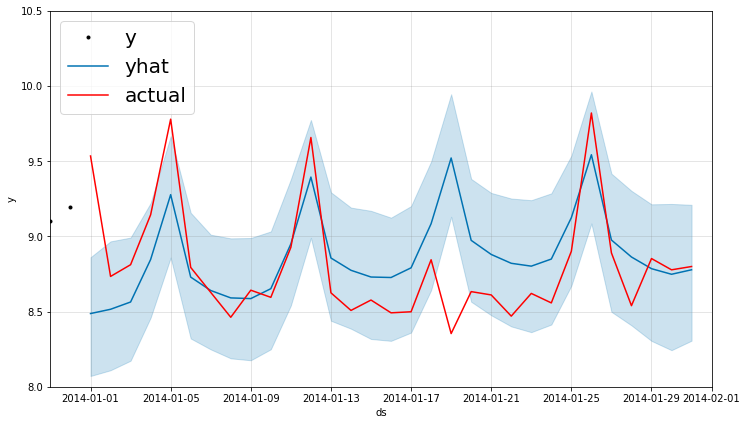

In [32]:
# Let's predict and have a look at how the new predictions compare with the actual values

df_dates = forecast_model.make_future_dataframe(periods=31, 
                                                include_history=False)
model_predictions = forecast_model.predict( df_dates )
plot_pred = forecast_model.plot( model_predictions )
plt.plot(df_dates, df_test, label="actual", color="r")
plt.legend(loc='best', fontsize=20)
plt.xlim('2013-12-30', '2014-02-01')
plt.ylim(8.0, 10.5)
plot_pred
plt.show()

That seems to be a bit better! Let's calculate the MAPE to compare with the original model.

In [33]:
mape(df_test, model_predictions["yhat"])

0.039381526136573676

Yes, a slight improvement, and similar to the ARIMA model MAPE. Further hyperparameter tuning could well lead to further model optimisation.